# Study and experiments with the MNIST dataset
---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


import math

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


## Some helper functions first 

In [2]:
# Plots the image represented by a row
def plot_number(row, w=28, h=28, labels=True):
    if labels:
        # the first column contains the label
        label = row[0]
        # The rest of columns are pixels
        pixels = row[1:]
    else:
        label = ''
        # The rest of columns are pixels
        pixels = row[0:]
    
#    print(row.shape, pixels.shape)
        

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    if labels:
        plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')

# Plots a whole slice of pictures
def plot_slice(rows, size_w=28, size_h=28, labels=True):
    num = rows.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(rows.ix[n], size_w, size_h, labels)
    plt.show()


### Loading the training set
Let's load the dataset and see some basic info

In [3]:
#train = pd.read_csv('../input/train.csv')
train = pd.read_csv('train.csv')
print(train.shape)
train.sample(5)


(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
21336,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17151,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2307,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Visualizing some rows

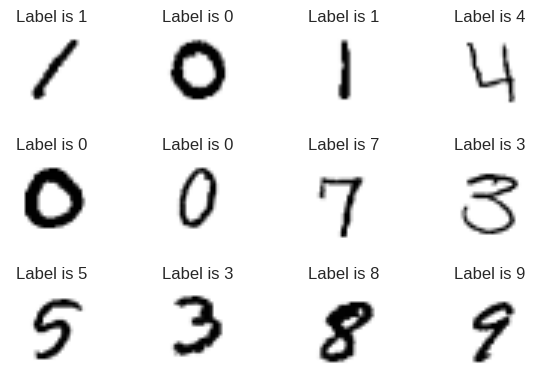

In [6]:
# Plotting first few rows
plot_slice(train[0:12])


## Dimensionality reduction

I try to see if a PCA can help to reduce the number of features without affecting too much information.

In [7]:
X_train = train.drop(['label'], axis='columns', inplace=False)
y_train = train['label']

In [8]:
n_components = len(X_train.columns) - 495
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)


done in 3.526s


0.98450562101633099

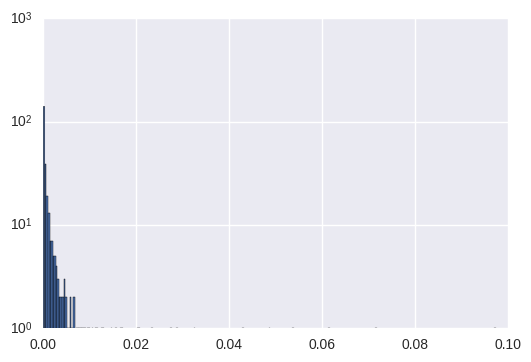

In [9]:
plt.hist(pca.explained_variance_ratio_, bins=n_components, log=True)
pca.explained_variance_ratio_.sum()


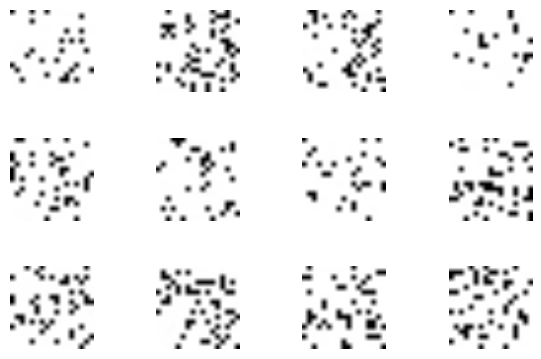

In [ ]:
plot_slice(pd.DataFrame(data=X_train_pca[12:24]), size_w=17, size_h=17, labels=False)

In [ ]:
t0 = time()
param_grid = [
  {'C': [1, 10], 'kernel': ['linear']},
]
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2, verbose=1)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
